In [59]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import os
import time
import pydrake
from pydrake.all import (
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
from geometric_only_grammar import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 1 child, 0. = infinite children)
- the region in which children will be produced (uniformly at random), in the frame of the node, in the form of an axis-aligned bounding box

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

Text(0.5, 1.0, 'Observed nodes')

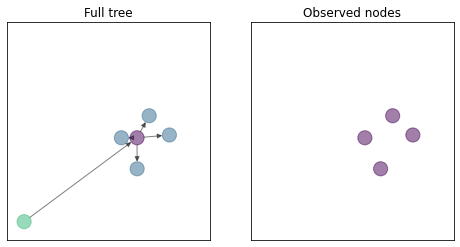

In [66]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    #"cluster_cluster": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[-np.ones(2)*0.2, np.ones(2)*0.22]),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=4, bounds=[-np.ones(2)*0.2, np.ones(2)*0.2]),
    "root": NodeDefinition(child_type="cluster", p=0.5, max_children=4, bounds=[np.ones(2)*0.2, np.ones(2)*0.8])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(7)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

Text(0.5, 1.0, 'Super tree for cluster grammar')

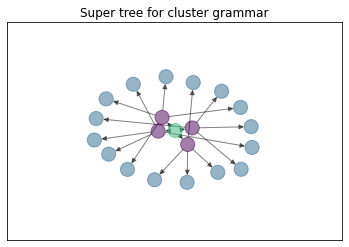

In [67]:

def make_super_tree(grammar):
    # Same logic as sampling a tree, but instead takes *all*
    # choices (but doesn't bother with sampling x).
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = parent_def.max_children

        for k in range(n_children):
            child = Node(parent_def.child_type, np.zeros(2))
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree
super_tree = make_super_tree(cluster_grammar)
draw_tree(super_tree, draw_pos=False)
plt.xlim([-2., 2.])
plt.ylim([-2., 2.])
plt.title("Super tree for cluster grammar")

# Posterior estimation on the super tree using full enumeration of trees

Now look at the full Bayesian form of scene parsing: given an observed scene $obs$ + a grammar description, find a representation of the posterior over parse trees $T$ for a given scene $obs$ that maximizes the (log) evidence:

$$ \log p(obs) = \log \left[ \sum_T p(obs | T) p(T)\right] $$

Now we need to worry about distributions over *whole trees*. Using the super-tree idea, we can describe any given tree as a binary vector $B = [b_1, ..., b_N]$ and continuous vector $C = [xy_1, ..., xy_N]$, concatenating the activation and xy variables for the $N$ nodes in the super tree. Distributions over trees are distributions over the joint space $p(B, C)$.

That space is nasty to represent, but we can try approximations -- here's a pretty exhaustive but expressive one:
1) For every distinct tree in the $2^N$ options (i.e. for each binary vector $B$), create decision variables as the parameters for a distribution over $C$. (i.e., fit a distribution for C for every distinct possible tree.)
2) Create $2^N$ continuous decision variables for the Categorical weights for a given tree / binary vector $B$ being chosen.

What distribution we use for $C$ probably depends on the grammar; maybe I can relate it to the variational approximation in VI.

The optimization becomes optimizing those parameters w.r.t.
$$
\begin{align}
\max \log p(obs) &= \log \left[ \sum_T p(obs | T) p(T) \right] \\
&\geq \sum_{T \, | \, p(obs | T) = 1 \, and \, p(T) > 0} \log p(T)
\end{align}$$

by dropping zero-probability terms from the sum and then applying Jensen's inequality. (In this situation, $p(obs | T)$ is still either 0 or 1, if the tree does or does node induce $obs$.)

Evaluation of $\log p(T)$ should be doable; the topology is fixed from the value for $B$, but the exact form of the parameter space for $C$ will decide how this is done.

Evaluation of $p(obs | T) = 1$ is a feasibility check: can the current tree produce the observation set? Importantly, this is a set-to-set evaluation: for each observed node, is the distance to the closest active node zero? (This requires a set of binary correspondence variables for each $T$...)
    
(I think that's going to create and explosion of variables, but we can try it.)

TODO(gizatt) IMPLEMENTATION BELOW IS TRASHY ABOUT COST: MIXES REGULAR PROB, LOG PROB, ETc.

KL divergence derivation:
Split $T$ into its discrete latent structure $B$; its continuous latent node positions $X$; and the latent-to-observed correspondences $C$.

Find $q(T)$ close to $p(T | o)$. Roughly following (6.1) in Ritchie's PhD thesis (but with a different setup) -- importantly, keeping the KL divergence ordering the same:
$$
\begin{align}
\min_\theta D_{KL}&(p(T | o) || q(T) \\
=& min_\theta \sum_{T} P(T | o) \log \dfrac{p(T | o)}{q(T)} \\ 
=& min_\theta \sum_{T \, s.t. \, P(T | o) > 0} P(T | o) \log p(T | o) - P(T | o) \log q_\theta(T) \\
=& max_\theta \sum_{T \, s.t. \, P(T | o) > 0} P(T | o) \log q_\theta(T) \\
=& max_\theta \sum_{\text{feasible } B} P(B) * \left[ \sum_{\text{feasible } X, C} P(X, C | o, B) \log q_{\theta}(B, X, C) \right]
\end{align}
$$
$q\theta(T)$ is parameterized by a set of weights $\theta^w$ over the feasible $B$, plus separate parameter sets $\theta^{XC}_i$ for variational posteriors over $X$ and $C$ for each feasible $B$.

In this strategy, we're taking the outer sum explicitly; but to estimate $P(X, C | o, B) \log q_\theta(B, X, C)$, we assume that posterior is concentrated at one optimal $X, C$ for each $o, B$, which we find and optimize jointly with $\theta$ in a MIP that looks like our oneshot parsing problem.

In [62]:
# Make a super tree and observed node set, which we'll modify to organize our optimization variables.
def infer_tree_dist_by_tree_enum(grammar, base_observed_nodes, observed_node_types, verbose=False):
    setup_start_time = time.time()
    base_super_tree = make_super_tree(grammar)
    base_observed_nodes = deepcopy(base_observed_nodes)

    prog = MathematicalProgram()

    # Assumption here that super_tree.nodes is consistently ordered before;after deepcopy.
    # Testing real quick...
    copied_nodes = deepcopy(base_super_tree).nodes
    assert([n1.type == n2.type and np.allclose(n1.x, n2.x)
            for n1, n2 in zip(base_super_tree.nodes, deepcopy(base_super_tree).nodes)])
    
    # Give nodes consistent and easy-to-get indices.
    for k, node in enumerate(base_super_tree.nodes):
        node.ind = k
    n_nodes = len(base_super_tree.nodes)
    n_combinations = 2**n_nodes
    all_super_trees = []
    all_observed_nodes = []

    # Create categorical weights.
    #categorical_weights = prog.NewContinuousVariables(n_combinations, "categorical_weights")
    #prog.AddLinearConstraint(sum(categorical_weights) == 1.)
    #prog.AddBoundingBoxConstraint(0, 1, categorical_weights)
    
    for combo_k in range(n_combinations):
        # Convert int to binary with zero padding on the front.
        node_activations = [int(i) for i in format(combo_k, '#0%db' % (n_nodes+2))[2:]]
        assert(len(node_activations) == n_nodes)
            
        # Pre-check basic tree feasibility, and reject & set weight
        # to zero & add no additional variables if it fails.
        def active(node):
            return node_activations[node.ind]
        def is_feasible(node_activations):
            for parent in list(base_super_tree.nodes):
                children = list(base_super_tree.successors(parent))
                # Enforce > 0 children for active nonterminals to have no hanging nonterminals.
                if active(parent) and grammar[parent.type].child_type is not None and sum([active(c) for c in children]) == 0:
                    return False
                # Child active -> parent active.
                for child in children:
                    if active(child) and not active(parent):
                        return False
                # Child ordering legal (always take earliest child).
                for child, next_child in zip(children[:-1], children[1:]):
                    if active(next_child) and not active(child):
                        return False

            # Number of active observed node types matches.
            for obs_type in observed_node_types:
                n_observed = len([o for o in base_observed_nodes if o.type == obs_type])
                n_active = len([n for n in base_super_tree if n.type == obs_type and active(n)])
                if n_observed != n_active:
                    return False
            return True

        if not is_feasible(node_activations):
            #prog.AddBoundingBoxConstraint(0., 0., categorical_weights[combo_k])
            all_super_trees.append(None)
            all_observed_nodes.append(None)
            continue
        
        # Now we know this tree *could* create the desired output, and we don't
        # need to enforce the above constraints.
        print("Got good tree config!")
        print("Node activations: ", node_activations)

        # Create a supertree and observed not set copy for data storage.
        super_tree = deepcopy(base_super_tree)
        # Record node active/not for convenience / reference later.
        for node in super_tree:
            node.active = active(node)
        all_super_trees.append(super_tree)
        observed_nodes = deepcopy(base_observed_nodes)
        all_observed_nodes.append(observed_nodes)
        
        # For each node, if it's not an observed type, create a uniform distribution on its x position.
        # Otherwise, create a Delta.
        for node_k, node in enumerate(super_tree.nodes):
            if node.type in observed_node_types:
                node.x_optim = prog.NewContinuousVariables(2, "%d_%d_x_delta" % (combo_k, node_k))
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim)
            else:
                node.x_optim_lb = prog.NewContinuousVariables(2, "%d_%d_x_lb" % (combo_k, node_k))
                node.x_optim_ub = prog.NewContinuousVariables(2, "%d_%d_x_lb" % (combo_k, node_k))
                # Finite support, please...
                for k in range(2):
                    prog.AddLinearConstraint(node.x_optim_lb[k] + 1E-6 <= node.x_optim_ub[k])
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_lb)
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_ub)
                if node.type is "root":
                    # Force to origin
                    prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_lb)
                    prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_ub)
        
        # We still aren't *guaranteed* feasibility; it's possible that there's no
        # physically valid arrangement of these nodes to match the observation. So
        # use a slack sort of arrangement to detect infeasibility.
        feasibility_indicator = prog.NewBinaryVariables(1, "%d_feas_slack" % combo_k)[0]

        #prog.AddLinearConstraint(categorical_weights[combo_k] <= feasibility_indicator)

        for parent_node in super_tree.nodes:
            children = list(super_tree.successors(parent_node))
            
            # The child support needs to be feasible no matter where the parent
            # is drawn in its own support.
            # TODO(gizatt) This is overly restrictive? It's like an inner approx
            # of the the support region?
            # This constraint is deactived if the feasibility indicator is off.
            if len(children) > 0:
                lb, ub = grammar[parent_node.type].bounds
            for child_node in children:
                if parent_node.type in observed_node_types:
                    raise NotImplementedError("Observed non-terminal not handled yet. Doable though?")
                if child_node.type in observed_node_types:
                    # | Child location - parent location| <= bounds.
                    M = 1. # Max position error in an axis
                    for k in range(2):
                        prog.AddLinearConstraint(
                            child_node.x_optim[k] >= parent_node.x_optim_ub[k] + lb[k]
                            - M * (1. - feasibility_indicator)
                        )
                        prog.AddLinearConstraint(
                            child_node.x_optim[k] <= parent_node.x_optim_lb[k] + ub[k]
                            + M * (1. - feasibility_indicator)
                        )
                else:
                    # Child lb and ub both need to be possible to be
                    # generated from the parent anywhere the parent can be drawn.
                    M = 1. # Max position error in an axis
                    for bound in [child_node.x_optim_lb, child_node.x_optim_ub]:
                        for k in range(2):
                            prog.AddLinearConstraint(
                                bound[k] >= parent_node.x_optim_ub[k] + lb[k]
                                - M * (1. - feasibility_indicator)
                            )
                            prog.AddLinearConstraint(
                                bound[k] <= parent_node.x_optim_lb[k] + ub[k]
                                + M * (1. - feasibility_indicator)
                            )
            
            # Child supports should be ordered, to break symmetries.
            for child, next_child in zip(children[:-1], children[1:]):
                if child.type in observed_node_types:
                    prog.AddLinearConstraint(next_child.x_optim[0] >= child.x_optim[0])
                else:
                    # TODO(gizatt) Upper bounds too? Worried about being too restrictive.
                    prog.AddLinearConstraint(next_child.x_optim_lb[0] >= child.x_optim_lb[0])
        
        # Finally, feasibility depends on existence of a legal corresponce between
        # the active observed nodes and observed nodes.
        for n in super_tree:
            # (first prep some bookkeeping)
            n.outgoings = []
        for observed_node in observed_nodes:
            possible_sources = [n for n in super_tree if n.type == observed_node.type and n.active]
            source_actives = prog.NewBinaryVariables(len(possible_sources), "%d_%s_sources" % (combo_k, observed_node.type))

            # Store these variables
            observed_node.source_actives = source_actives
            for k, n in enumerate(possible_sources):
                n.outgoings.append(source_actives[k])

            # Each observed node needs exactly one explaining input.
            # (This is relaxed is feasibility is impossible, which allows the
            # trivial solution that the observed node is unexplained and supplies no
            # constraints to the dead / zero-prob supertree.)
            prog.AddLinearEqualityConstraint(sum(source_actives) == feasibility_indicator)

            for k, node in enumerate(possible_sources):
                M = 1. # Should upper bound positional error in any single dimension
                # When correspondence is active, force the node to match the observed node.
                # Otherwise, it can vary within a big M of the observed node.
                for i in range(2):
                    prog.AddLinearConstraint(node.x_optim[i] <= observed_node.x[i] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.x_optim[i] >= observed_node.x[i] - 1E-6 - (1. - source_actives[k]) * M)

        # Go back and make sure no node in the super tree is being used
        # to explain more than one observed node.
        for node in super_tree:
            if node.type in observed_node_types:
                if len(node.outgoings) > 0:
                    prog.AddLinearConstraint(sum(node.outgoings) <= 1)

        # Finally, pull out probabilities from the tree.
        # Apply a massive negative penalty if this tree arrangement is deactived,
        # since that would be an admission that P(T) = 0, and deactive the penalty
        # if not.
        M = 100.
        
        total_log_prob = -M * (1. - feasibility_indicator) # 0. # = categorical_weights[combo_k]
        log_prob_of_tree_structure = 0.
        # And sum of log probs of discrete and continuous choices in tree.
        for parent_node in super_tree.nodes:
            children = list(super_tree.successors(parent_node))
            # Geometric value of having this # of children.
            active_children = [c for c in children if c.active]
            if len(active_children) > 0:
                p = grammar[parent_node.type].p
                log_prob_of_tree_structure += np.log((1. - p) ** len(active_children) * p)
                for child in active_children:
                    # Density of child support region
                    if child.type in observed_node_types:
                        # Delta, no density
                        pass
                    else:
                        # TODO(gizatt) This isn't quite right -- need log() this difference...
                        # TODO Full maximum entropy derivation, gonna be rough...
                        total_log_prob += sum(child.x_optim_ub - child.x_optim_lb)

        super_tree.total_log_prob = total_log_prob
        super_tree.log_prob_of_tree_structure = log_prob_of_tree_structure
        super_tree.feasibility_indicator = feasibility_indicator
        # Maximize log prob, so min -ll.
        prog.AddLinearCost(-total_log_prob)

    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    if verbose:
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
        print("Setup time: ", time.time() - setup_start_time)
    solve_start_time = time.time()
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Solve time: ", time.time() - solve_start_time)
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    
    # Post-process a bit: for each feasible tree, grab the computed log-density
    # of that tree to build the categorical weights.
    categorical_weights_ll = []
    for super_tree in all_super_trees:
        if super_tree is None or not result.GetSolution(super_tree.feasibility_indicator):
            categorical_weights_ll.append(-1E10)
        else:
            ll = result.GetSolution(super_tree.log_prob_of_tree_structure).Evaluate()
            print(result.GetSolution(super_tree.feasibility_indicator), ll)
            categorical_weights_ll.append(ll)
    # Normalize in log space since some of the values will be nasty.
    categorical_weights_ll -= sp.special.logsumexp(categorical_weights_ll)
    categorical_weights = np.exp(categorical_weights_ll)
    TreeDistInferenceResults = namedtuple(
        "TreeDistInferenceResults",
        ["optim_result", "categorical_weights", "all_super_trees", "all_observed_nodes", "base_observed_nodes", "grammar", "observed_node_types"]
    )
    return TreeDistInferenceResults(
        result, categorical_weights, all_super_trees, all_observed_nodes,
        base_observed_nodes, grammar, observed_node_types
    )

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
print("Starting with %d observed nodes" % len(observed_nodes))
start_time = time.time()
inference_results = infer_tree_dist_by_tree_enum(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)
print("Nonzero categorical weights: ", [c for c in inference_results.categorical_weights if c > 0])
print("Sparsity: %d/%d weights are nonzero." % (
    len([c for c in inference_results.categorical_weights if c > 0]),
    len(inference_results.categorical_weights)
))

Starting with 3 observed nodes
Got good tree config!
Node activations:  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Got good tree config!
Node activations:  [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Got good tree config!
Node activations:  [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Got good tree config!
Node activations:  [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]
Num vars:  176
Num constraints:  624
Setup time:  0.15740609169006348
Optimization success?:  True
Solve time:  0.037956953048706055
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 22:58:33 2021


1.0 -3.635634939595124
1.0 -5.715076481274959
1.0 -5.71507648127496
1.0 -7.7945180229547955
Took 0.221015 secs
Nonzero categorical weights:  [0.7901234567901236, 0.09876543209876551, 0.09876543209876543, 0.012345679012345685]
Sparsity: 4/8192 weights are nonzero.


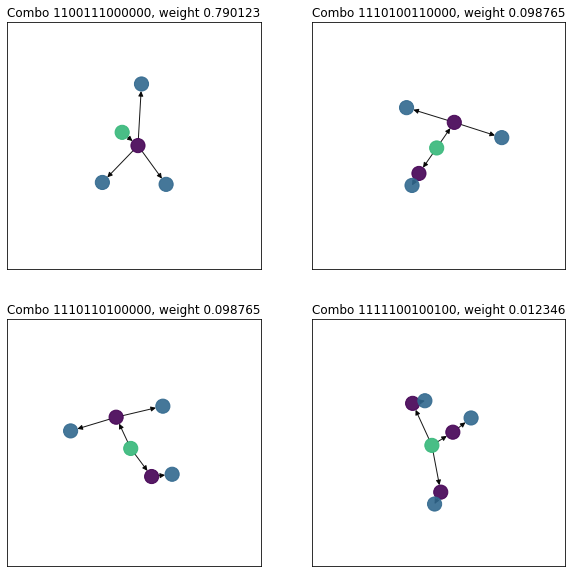

In [63]:
# Draw all ways of explaining the given scene, with support boxes for each node type.
# Sample trees from the results:
from matplotlib.patches import Rectangle
def draw_all_explanations(inference_results, width=None, draw_as_supertree=False):
    nonzero_weights_and_combos = [(k, w) for k, w in enumerate(inference_results.categorical_weights) if w > 1E-4]
    if width:
        height = len(nonzero_weights_and_combos) // width
        plt.figure().set_size_inches(5*width, 5*height)
    for k, (combo_k, weight) in enumerate(nonzero_weights_and_combos):
        if width:
            plt.subplot(width, height, k+1)
        else:
            plt.figure().set_size_inches(5, 5)
        
        # Grab that supertree from optimization
        optim_result = inference_results.optim_result
        super_tree = inference_results.all_super_trees[combo_k]
        assert optim_result.GetSolution(super_tree.feasibility_indicator)
        observed_nodes = inference_results.all_observed_nodes[combo_k]
        observed_node_types = inference_results.observed_node_types

        # Sanity-check observed nodes are explained properly.
        for observed_node in observed_nodes:
            if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
                print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

        illustration_tree = nx.DiGraph()
        colors_by_type = {}
        node_colors = {}
        for node in super_tree:
            if node.active:
                illustration_tree.add_node(node)
                color = plt.get_cmap("jet")(np.random.random())
                node_colors[node] = color
                # Put node xy at center of support region
                # and draw support regions
                if node.type in observed_node_types:
                    # Node xy distribution is delta -> copy it over
                    node.x = optim_result.GetSolution(node.x_optim)
                else:
                    # Node xy distribution is Uniform -> sample
                    lb = optim_result.GetSolution(node.x_optim_lb)
                    ub = optim_result.GetSolution(node.x_optim_ub)
                    node.x = (lb + ub) / 2.
                    if not draw_as_supertree:
                        plt.gca().add_patch(
                            Rectangle(lb, ub[0]-lb[0], ub[1]-lb[1],
                                     color=color,
                                     alpha=0.5))
                parents = list(super_tree.predecessors(node))
                assert len(parents) <= 1
                if len(parents) == 1:
                    parent = parents[0]
                    assert parent.active
                    illustration_tree.add_edge(parent, node)
        # Draw
        if draw_as_supertree:
            draw_tree(illustration_tree, alpha=0.9, ax=plt.gca(), draw_pos=False)
            plt.gca().set_xlim(-2, 2)
            plt.gca().set_ylim(-2, 2)
        else:
            draw_tree(illustration_tree, alpha=0.5, ax=plt.gca(), node_size=50)
        binary_string = format(combo_k, '#0%db' % (len(super_tree.nodes)+2))[2:]
        plt.title("Combo %0s, weight %f" % (binary_string, weight))

draw_all_explanations(inference_results, draw_as_supertree=True, width=2)

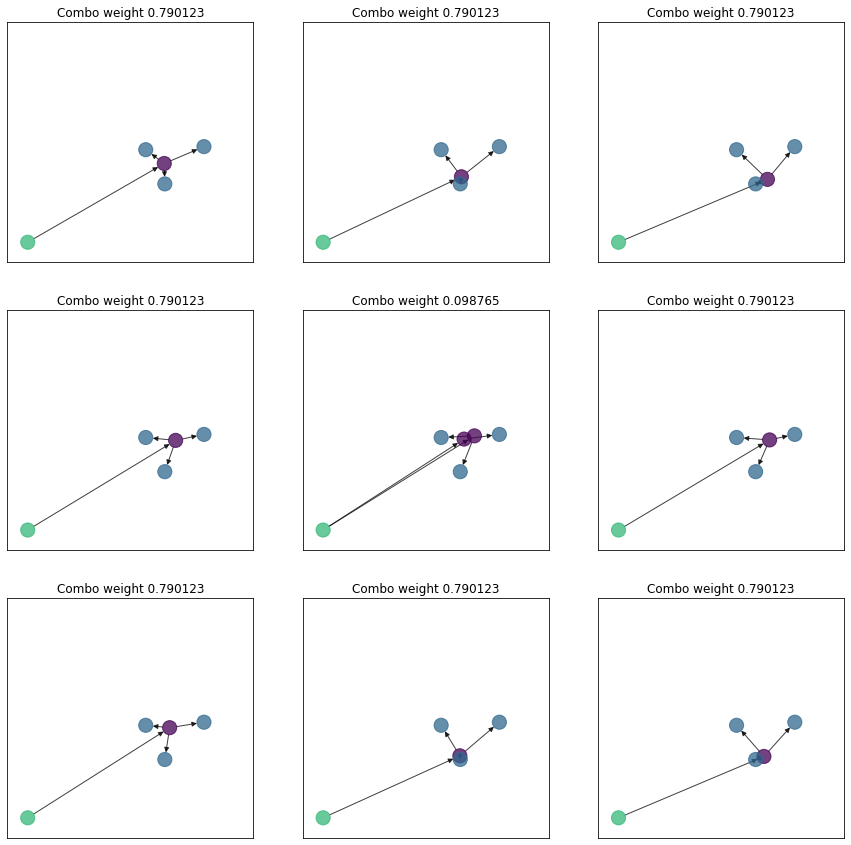

In [64]:
# Sample trees from the results:
def sample_tree_from_results(inference_results):
    # Pick which tree structure
    weights = inference_results.categorical_weights
    combo_k = np.random.choice(len(weights),p=weights)
    
    # Grab that supertree from optimization
    optim_result = inference_results.optim_result
    super_tree = inference_results.all_super_trees[combo_k]
    assert optim_result.GetSolution(super_tree.feasibility_indicator)
    observed_nodes = inference_results.all_observed_nodes[combo_k]
    observed_node_types = inference_results.observed_node_types

    # Sanity-check observed nodes are explained properly.
    for observed_node in observed_nodes:
        if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

    sampled_tree = nx.DiGraph()
    super_tree = deepcopy(super_tree)
    for node in super_tree:
        if node.active:
            sampled_tree.add_node(node)
            # Sample node xy
            if node.type in observed_node_types:
                # Node xy distribution is delta -> copy it over
                node.x = optim_result.GetSolution(node.x_optim)
            else:
                # Node xy distribution is Uniform -> sample
                lb = optim_result.GetSolution(node.x_optim_lb)
                ub = optim_result.GetSolution(node.x_optim_ub)
                node.x = np.random.uniform(lb, ub)
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert parent.active
                sampled_tree.add_edge(parent, node)
    return sampled_tree, weights[combo_k]

width = 3
height = 3
plt.figure().set_size_inches(5*width, 5*height)
for k in range(width*height):
    plt.subplot(width, height, k+1)
    sampled_tree, weight = sample_tree_from_results(inference_results)
    draw_tree(sampled_tree, alpha=0.75, ax=plt.gca())
    plt.title("Combo weight %f" % weight)

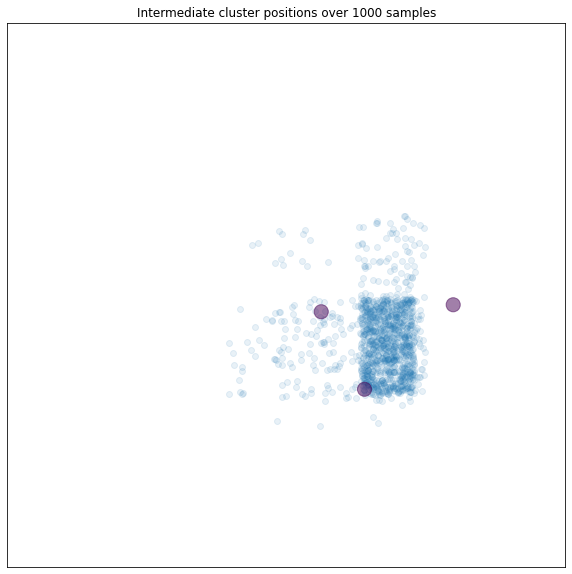

In [7]:
# Plot intermediate node density as a heatmap, overlaid on
from scipy.stats.kde import gaussian_kde

def draw_intermediate_node_heatmaps(inference_results, n_samples=1000):
    grammar = inference_results.grammar
    observed_node_types = inference_results.observed_node_types
    non_root_non_observed_types = [type for type in grammar.keys() if type not in observed_node_types and type is not "root"]
    # Sample a bunch of trees
    trees = [sample_tree_from_results(inference_results) for k in range(n_samples)]
    # Pick out nodes of each type
    by_type = {type: [] for type in non_root_non_observed_types}
    for tree, weight in trees:
        for type in by_type.keys():
            by_type[type] += [(n, weight) for n in tree.nodes if n.type == type]
    plt.figure().set_size_inches(10, 10)
    for k, type in enumerate(by_type.keys()):
        ax = plt.subplot(1, len(non_root_non_observed_types), k+1)
        x = [n.x[0] for n, _ in by_type[type]]
        y = [n.x[1] for n, _ in by_type[type]]
        weights = [w for _, w in by_type[type]]
        
        #k = gaussian_kde(np.vstack([x, y]), weights=weights)
        #xi, yi = np.mgrid[0:1:0.01,0:1:0.01]
        #zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        #plt.gca().pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.75, cmap=plt.get_cmap("GnBu"))
        #plt.gca().contourf(xi, yi, zi.reshape(xi.shape), alpha=1.0, cmap=plt.get_cmap("GnBu"))
        plt.scatter(x, y, alpha=0.1)

        draw_observed_nodes(inference_results.base_observed_nodes)
        plt.title("Intermediate %s positions over %d samples" % (type, n_samples))
        plt.gca().add_patch(Rectangle([0, 0], 1, 1, facecolor='none'))
draw_intermediate_node_heatmaps(inference_results, n_samples=1000)

In [45]:
# Try to sample scenes with matching observation
sampled_scenes = []
EPS = 0.1
our_x = np.stack([n.x for n in observed_nodes], axis=0)
print(our_x)
print(our_x.shape)
for k in range(1000000):
    if k % 25000 == 0:
        print(k)
    guess_tree = sample_tree(cluster_grammar)
    guess_observed_nodes = deepcopy(get_observed_nodes(guess_tree, cluster_grammar_observed_types))
    if len(guess_observed_nodes) == len(observed_nodes):
        good = True
        for n in guess_observed_nodes:
            if np.min(np.sum(np.abs(our_x - n.x), axis=-1)) >= EPS:
                good = False
                break
        if good:
            sampled_scenes.append(guess_tree)
print("Got %d scenes" % len(sampled_scenes))

[[0.85914708 0.47844389]
 [0.66839946 0.29186599]
 [0.57532687 0.46299854]]
(3, 2)
0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000
500000
525000
550000
575000
600000
625000
650000
675000
700000
725000
750000
775000
800000
825000
850000
875000
900000
925000
950000
975000
Got 1666 scenes


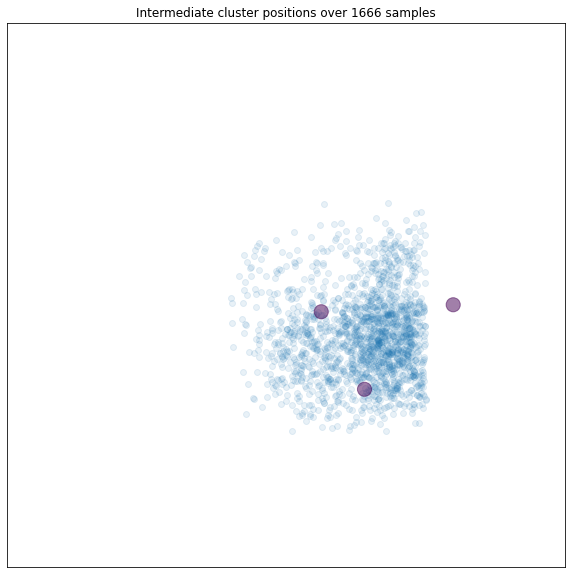

In [65]:
# Plot intermediate node density as a heatmap, overlaid on
from scipy.stats.kde import gaussian_kde

def draw_intermediate_node_heatmaps_for_sampled_scenes(trees, grammar, observed_node_types):
    # Pick out nodes of each type
    non_root_non_observed_types = [type for type in grammar.keys() if type not in observed_node_types and type is not "root"]
    by_type = {type: [] for type in non_root_non_observed_types}
    for tree in trees:
        for type in by_type.keys():
            by_type[type] += [n for n in tree.nodes if n.type == type]
    plt.figure().set_size_inches(10, 10)
    for k, type in enumerate(by_type.keys()):
        ax = plt.subplot(1, len(non_root_non_observed_types), k+1)
        x = [n.x[0] for n in by_type[type]]
        y = [n.x[1] for n in by_type[type]]
        
        #k = gaussian_kde(np.vstack([x, y]), weights=weights)
        #xi, yi = np.mgrid[0:1:0.01,0:1:0.01]
        #zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        #plt.gca().pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.75, cmap=plt.get_cmap("GnBu"))
        #plt.gca().contourf(xi, yi, zi.reshape(xi.shape), alpha=1.0, cmap=plt.get_cmap("GnBu"))
        plt.scatter(x, y, alpha=0.1)

        draw_observed_nodes(inference_results.base_observed_nodes)
        plt.title("Intermediate %s positions over %d samples" % (type, len(trees)))
        plt.gca().add_patch(Rectangle([0, 0], 1, 1, facecolor='none'))
draw_intermediate_node_heatmaps_for_sampled_scenes(sampled_scenes, cluster_grammar, cluster_grammar_observed_types)